In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sklearn
import sys

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

IMAGE_PATH = os.path.join('./images')


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Loading the data

In [2]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [3]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [4]:
song_dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40560 entries, 0 to 40559
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40560 non-null  float64
 1   popularity        40560 non-null  float64
 2   acousticness      40560 non-null  float64
 3   danceability      40560 non-null  float64
 4   duration_ms       40560 non-null  float64
 5   energy            40560 non-null  float64
 6   instrumentalness  40560 non-null  float64
 7   key               40560 non-null  object 
 8   liveness          40560 non-null  float64
 9   loudness          40560 non-null  float64
 10  mode              40560 non-null  object 
 11  speechiness       40560 non-null  float64
 12  tempo             40560 non-null  float64
 13  valence           40560 non-null  float64
 14  music_genre       40560 non-null  object 
dtypes: float64(12), object(3)
memory usage: 4.6+ MB


In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

In [6]:
song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [7]:
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

In [8]:
song_filled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        50000 non-null  float64
 1   acousticness      50000 non-null  float64
 2   danceability      50000 non-null  float64
 3   duration_ms       50000 non-null  float64
 4   energy            50000 non-null  float64
 5   instrumentalness  50000 non-null  float64
 6   key               50000 non-null  int64  
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   mode              50000 non-null  int64  
 10  speechiness       50000 non-null  float64
 11  tempo             50000 non-null  float64
 12  valence           50000 non-null  float64
 13  music_genre       50000 non-null  object 
dtypes: float64(11), int64(2), object(1)
memory usage: 5.3+ MB


# Modeling

## Splitting the data

Separating data from labels

In [9]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [10]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the splits

In [11]:
from sklearn.model_selection import train_test_split

# audio data with means
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


## Training

### Decision Tree - Gini Index

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

clf1_audio = DecisionTreeClassifier(criterion='gini', max_depth=6).fit(X_audio_train, y_audio_train)
clf1_dropped = DecisionTreeClassifier(criterion='gini', max_depth=6).fit(X_dropped_train, y_dropped_train)
clf1_filled = DecisionTreeClassifier(criterion='gini', max_depth=6).fit(X_filled_train, y_filled_train)

y_pred_audio = clf1_audio.predict(X_audio_test)
y_pred_dropped = clf1_dropped.predict(X_dropped_test)
y_pred_filled = clf1_filled.predict(X_filled_test)

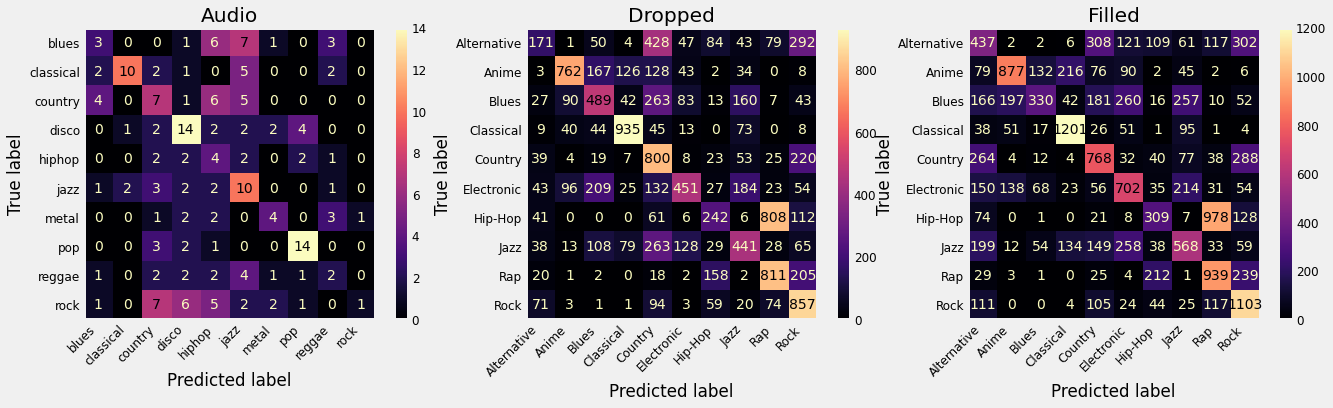

In [13]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

plot_confusion_matrix(clf1_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
plot_confusion_matrix(clf1_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(clf1_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)

plt.show()

In [14]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)




Audio
               precision    recall  f1-score   support

       blues       0.25      0.14      0.18        21
   classical       0.77      0.45      0.57        22
     country       0.24      0.30      0.27        23
       disco       0.42      0.52      0.47        27
      hiphop       0.13      0.31      0.19        13
        jazz       0.27      0.48      0.34        21
       metal       0.40      0.31      0.35        13
         pop       0.64      0.70      0.67        20
      reggae       0.17      0.13      0.15        15
        rock       0.50      0.04      0.07        25

    accuracy                           0.34       200
   macro avg       0.38      0.34      0.33       200
weighted avg       0.40      0.34      0.33       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.37      0.14      0.21      1199
       Anime       0.75      0.60      0.67      1273
       Blues       0.45      0.40      0.42      1217
   C

In [15]:
# %pip install pydotplus

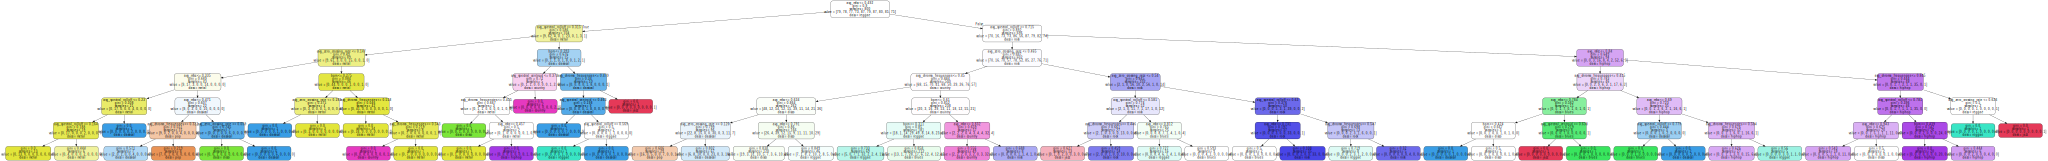

In [16]:
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus

dot_data = export_graphviz(
    clf1_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(IMAGE_PATH, "audio_tree1.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


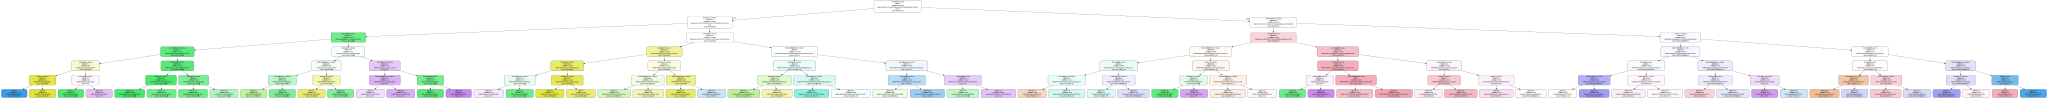

In [17]:
dot_data = export_graphviz(
    clf1_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(IMAGE_PATH, "dropped_tree1.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


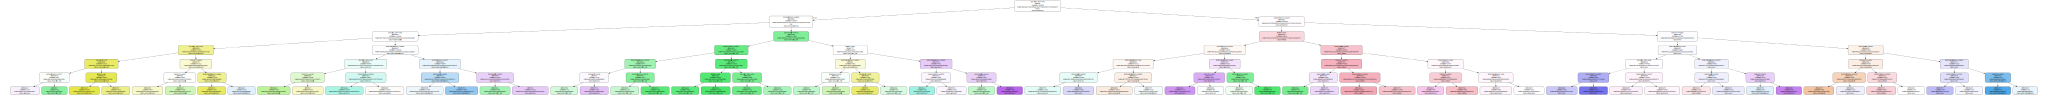

In [18]:
dot_data = export_graphviz(
    clf1_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(IMAGE_PATH, "filled_tree1.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

### Decision Tree - Entropy

In [19]:
clf2_audio = DecisionTreeClassifier(
    criterion='entropy', max_depth=6).fit(X_audio_train, y_audio_train)
clf2_dropped = DecisionTreeClassifier(
    criterion='entropy', max_depth=6).fit(X_dropped_train, y_dropped_train)
clf2_filled = DecisionTreeClassifier(
    criterion='entropy', max_depth=6).fit(X_filled_train, y_filled_train)

y_pred_audio = clf2_audio.predict(X_audio_test)
y_pred_dropped = clf2_dropped.predict(X_dropped_test)
y_pred_filled = clf2_filled.predict(X_filled_test)


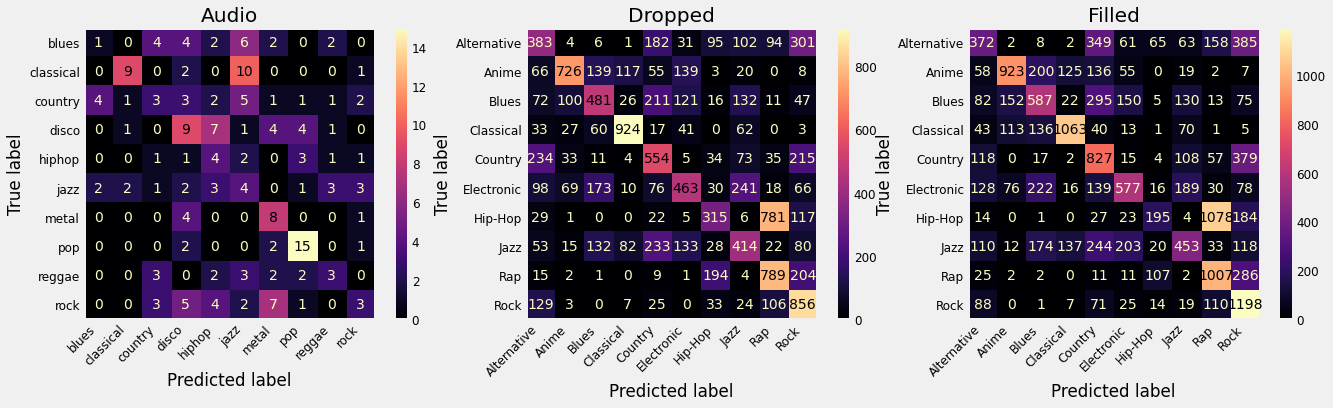

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(clf2_audio, X_audio_test,
                      y_audio_test, ax=axs[0], cmap='magma')
plot_confusion_matrix(clf2_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(clf2_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)

plt.show()


In [21]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.14      0.05      0.07        21
   classical       0.69      0.41      0.51        22
     country       0.20      0.13      0.16        23
       disco       0.28      0.33      0.31        27
      hiphop       0.17      0.31      0.22        13
        jazz       0.12      0.19      0.15        21
       metal       0.31      0.62      0.41        13
         pop       0.56      0.75      0.64        20
      reggae       0.27      0.20      0.23        15
        rock       0.25      0.12      0.16        25

    accuracy                           0.29       200
   macro avg       0.30      0.31      0.29       200
weighted avg       0.30      0.29      0.28       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.34      0.32      0.33      1199
       Anime       0.74      0.57      0.64      1273
       Blues       0.48      0.40      0.43      1217
   C

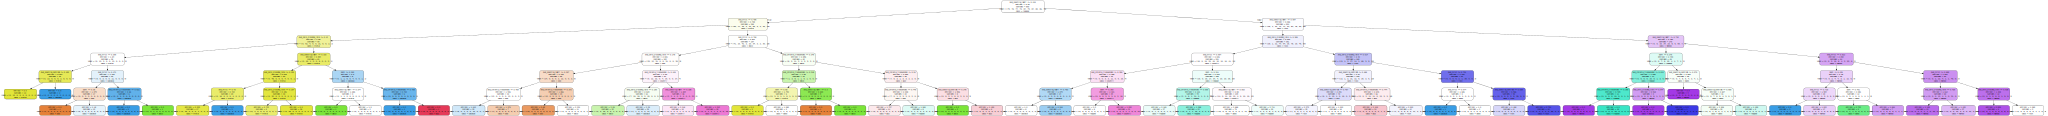

In [23]:
dot_data = export_graphviz(
    clf2_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)
out_file = os.path.join(IMAGE_PATH, "audio_tree2.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,65!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


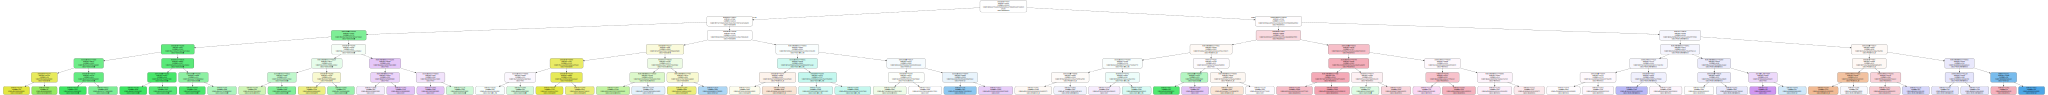

In [24]:
dot_data = export_graphviz(
    clf2_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(IMAGE_PATH, "dropped_tree2.pdf")
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

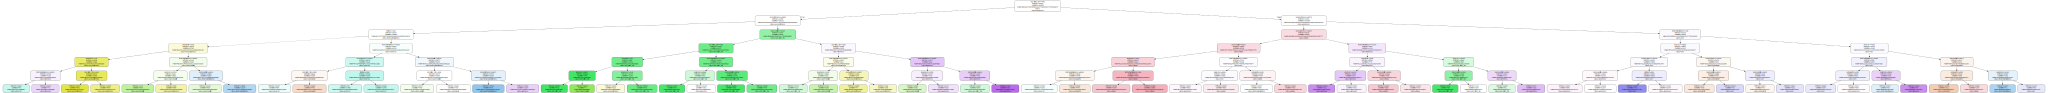

In [25]:
dot_data = export_graphviz(
    clf2_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)

out_file = os.path.join(IMAGE_PATH, "filled_tree2.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

### kNN Classifier

### Logistic Regression

### Random Forest